In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import re

In [ ]:
OUTPUT_FILE = "Hashtags_Cambiemos_28SEP.json"

# Initialize empty list to store tweets
tweets_data = []

# Open connection to file
with open(OUTPUT_FILE, "r") as tweets_file:
    # Read in tweets and store in list
    for line in tweets_file:
        tweet = json.loads(line)
        tweets_data.append(tweet)

In [ ]:
df = pd.DataFrame(tweets_data, columns=['user','created_at', 'text'])
df.head()

In [830]:
def populate_tweet_df(tweets):
 
    df['user_id'] = list(map(lambda tweet: tweet['user']['id'], tweets))
 
    df['user_name'] = list(map(lambda tweet: tweet['user']['name'], tweets))
    
    df['location'] = list(map(lambda tweet: tweet['user']['location'], tweets))
 
    df['retweeted_from'] = list(map(lambda tweet: tweet['retweeted_status']['user']['id']
                                  if 'retweeted_status' in tweet.keys() else '', tweets))
 
    df['orignal_text'] = list(map(lambda tweet: tweet['retweeted_status']['text']
                                  if 'retweeted_status' in tweet.keys() else '', tweets))
    
    df['tweet_id'] = list(map(lambda tweet: tweet['retweeted_status']['id']
                                  if 'retweeted_status' in tweet.keys() else '', tweets))
    
    
    return df


df = populate_tweet_df(tweets_data)
df.head()

user  \
0  {'id': 24900072, 'id_str': '24900072', 'name':...   
1  {'id': 923314182614847488, 'id_str': '92331418...   
2  {'id': 1161654740188573696, 'id_str': '1161654...   
3  {'id': 2900846036, 'id_str': '2900846036', 'na...   
4  {'id': 527026096, 'id_str': '527026096', 'name...   

                       created_at  \
0  Sat Sep 28 19:25:27 +0000 2019   
1  Sat Sep 28 19:25:27 +0000 2019   
2  Sat Sep 28 19:25:28 +0000 2019   
3  Sat Sep 28 19:25:28 +0000 2019   
4  Sat Sep 28 19:25:28 +0000 2019   

                                                text              user_id  \
0                     #YoVoy https://t.co/noGXUqYZBu             24900072   
1  Vamossss, desde el interior haciendo el aguant...   923314182614847488   
2  RT @marceldancearg: 🇦🇷#SiSePuedeBelgrano \nHoy...  1161654740188573696   
3  RT @TotyFlores: Rumbo a la marcha del #SiSePue...           2900846036   
4  RT @RicBenedetti: Junto a @herlombardi Vamos c...            527026096   

                                         user_name  \
0                                   Mauricio Macri   
1                     Que especie rara la tuya!! 😘   
2  Ex Mer, ex Maria Mercedes, soy 💙MER RECARGADA🇦🇷   
3                                      maria lopez   
4                                             More   

                       location retweeted_from  \
0       Buenos Aires, Argentina                  
1  Corrientes,(país a parte) 🇦🇷                  
2                          None     2609748196   
3                       Coghlan      126291236   
4         Corrientes, Argentina       71360442   

                                        orignal_text             tweet_id  
0                                                                          
1                                                                          
2  🇦🇷#SiSePuedeBelgrano \nHoy Barrancas de Belgra...  1177941082518278144  
3  Rumbo a la marcha del #SiSePuede  \n\n@maurici...  1178026748627300352  
4  Junto a @herlombardi Vamos carajo la damos vue...  1178027036931215360

In [ ]:
nodes = df['user_id'].drop_duplicates().dropna()

In [ ]:
edges = df[df['retweeted_from']!=''][['user_id', 'retweeted_from']].drop_duplicates()

In [ ]:
nodes = pd.merge(nodes, edges.groupby('user_id').count().rename(columns={'retweeted_from': 'out'}), how='left',
            left_on='user_id', right_on='user_id').fillna(0)

nodes = pd.merge(nodes, edges.groupby('retweeted_from').count().rename(columns={'user_id': 'in'}), how='left',
            left_on='user_id', right_on='retweeted_from').fillna(0)

nodes = nodes[nodes['in'] > 0]
nodes = nodes[nodes['out'] > 0]

In [ ]:
G = nx.from_pandas_dataframe(edges, 'user_id', 'retweeted_from', create_using=nx.DiGraph())
nx.set_node_attributes(G, 'in', pd.Series(nodes['in'].to_list(), index=nodes.user_id).to_dict())
nx.set_node_attributes(G, 'out', pd.Series(nodes['out'].to_list(), index=nodes.user_id).to_dict())
#Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
#Gcc_dyn = sorted(nx.connected_component_subgraphs(G_dyn), key=len, reverse=True)[0]

## Degrees

In [ ]:
degrees = G.degree()
out_degrees = G.out_degree()
in_degrees = G.in_degree()

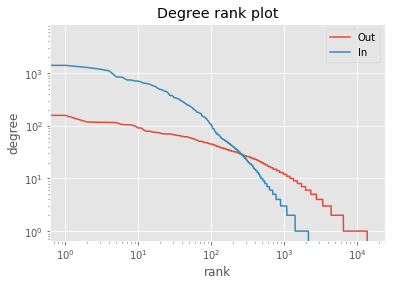

In [831]:
with plt.style.context('ggplot'):
    
    plt.loglog(sorted([out_degrees[n] for n in out_degrees], reverse=True))
    plt.loglog(sorted([in_degrees[n] for n in in_degrees], reverse=True))
    plt.title("Degree rank plot")
    plt.legend(['Out', 'In'])
    plt.ylabel("degree")
    plt.xlabel("rank")

## Connected Components

In [ ]:
def get_strongly_cc(G, node):
    """ get storngly connected component of node""" 
    for cc in nx.strongly_connected_components(G):
        if node in cc:
            return cc
    else:
        return set()

def get_weakly_cc(G, node):
    """ get weakly connected component of node""" 
    for cc in nx.weakly_connected_components(G):
        if node in cc:
            return cc
    else:
        return set()

In [ ]:
WGcc = []
for node in G.nodes():
    weak_component = get_weakly_cc(G, node)  # Weakly connected component of node in G
    if len(weak_component) > len(WGcc):
        WGcc = weak_component
    
SGcc = []
for node in G.nodes():
    strong_component = get_strongly_cc(G, node)  # Weakly connected component of node in G
    if len(strong_component) > len(SGcc):
        SGcc = strong_component

In [ ]:
SGcc = G.subgraph(SGcc)
WGcc = G.subgraph(WGcc)

In [ ]:
SGcc = SGcc.to_undirected()
SGcc_degree = SGcc.degree()

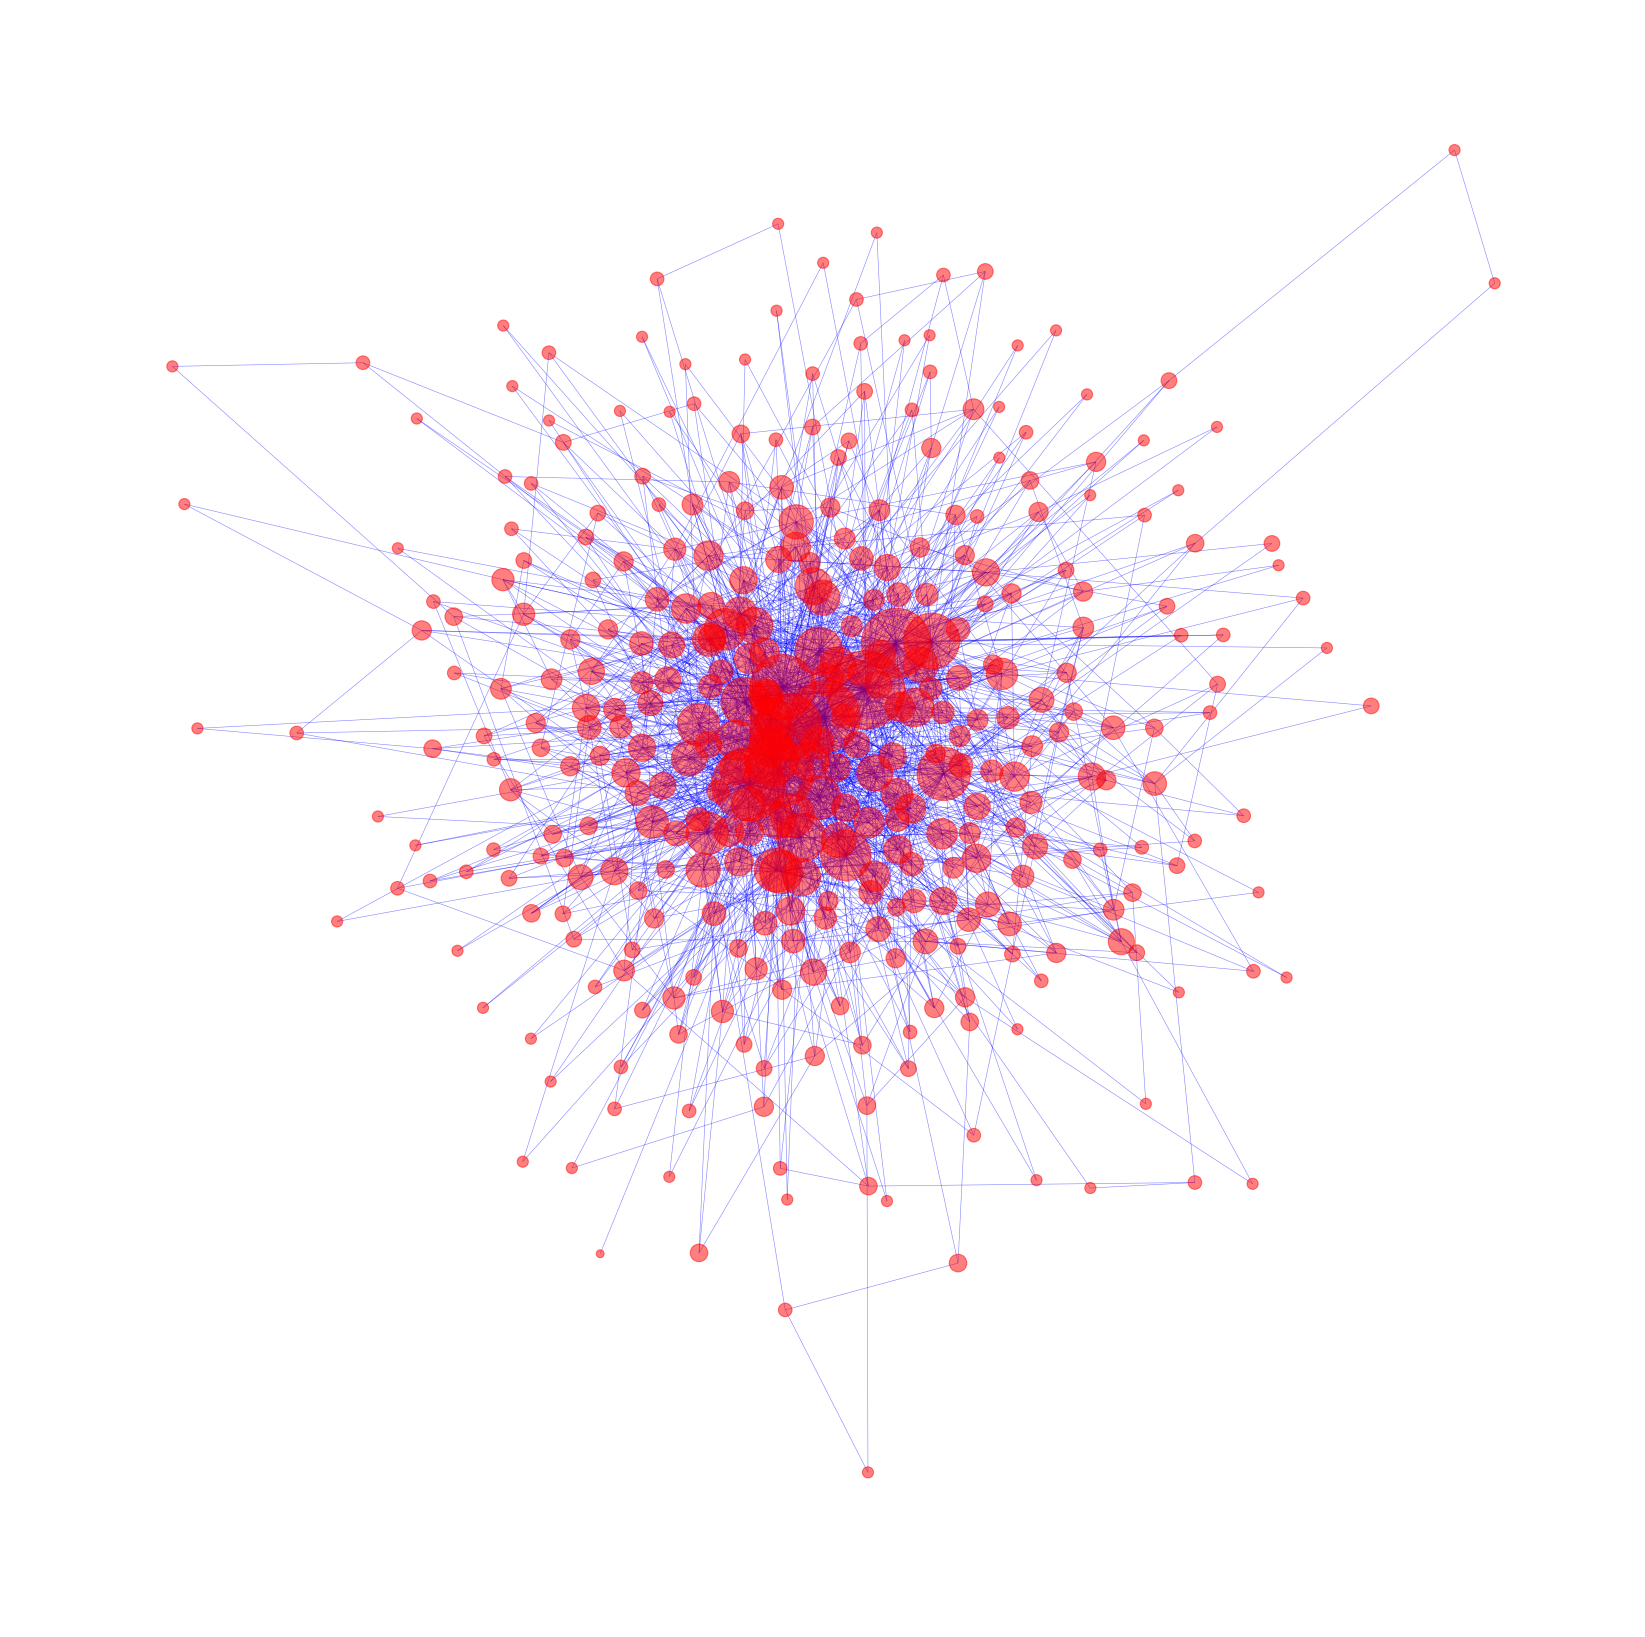

In [832]:
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

pos = nx.spring_layout(SGcc)

nx.draw(SGcc, pos, nodelist=SGcc_degree.keys(), node_size=[v * 50 for v in SGcc_degree.values()], 
       width=0.5, alpha=0.5, edge_color='b')

plt.axis('off')
plt.show()

## Dynamic Plot

In [ ]:
edges_dyn = df[df['retweeted_from']!=''][['user_id', 'retweeted_from', 'created_at']].drop_duplicates()
edges_dyn = edges_dyn.sort_values(by='created_at', ascending=True)
G_dyn = nx.from_pandas_dataframe(edges_dyn, 'user_id', 'retweeted_from', 'created_at', create_using=nx.DiGraph())

In [ ]:
SGcc_dyn = []
for node in G_dyn.nodes():
    strong_component = get_strongly_cc(G_dyn, node)  
    if len(strong_component) > len(SGcc_dyn):
        SGcc_dyn = strong_component

In [ ]:
SGcc_dyn = G_dyn.subgraph(SGcc_dyn)
SGcc_dyn = SGcc_dyn.to_undirected()
SGcc_dyn_degree = SGcc_dyn.degree()

In [ ]:
fig_animated = plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, bitrate=1800)

pos = nx.spring_layout(SGcc_dyn)
#nx.draw_networkx_nodes(SGcc_dyn, pos)
nx.draw_networkx_nodes(SGcc, pos, nodelist=SGcc_degree.keys(), alpha=0.5,
                       node_size=[v * 50 for v in SGcc_degree.values()])

def animate(i):
    #time = edges_dyn['created_at'].tolist()[i]
    time = sorted(SGcc_dyn.edges(data=True), key=lambda x: x[2]['created_at'])[i][2]['created_at']
    frame = [(u, v) for (u, v, d) in SGcc_dyn.edges(data=True) if d['created_at'] == time]
    nx.draw_networkx_edges(SGcc_dyn, pos, edgelist=frame, width=0.5, alpha=0.5, edge_color='b')
    
    
ani = matplotlib.animation.FuncAnimation(fig_animated, animate, frames=len(SGcc_dyn.edges()), repeat=True)
ani.save('Dynamic_graph.mp4', writer=writer)

In [829]:
import os
os.system("ffmpeg -i Dynamic_graph.mp4 Dynamic_graph3.gif")

0

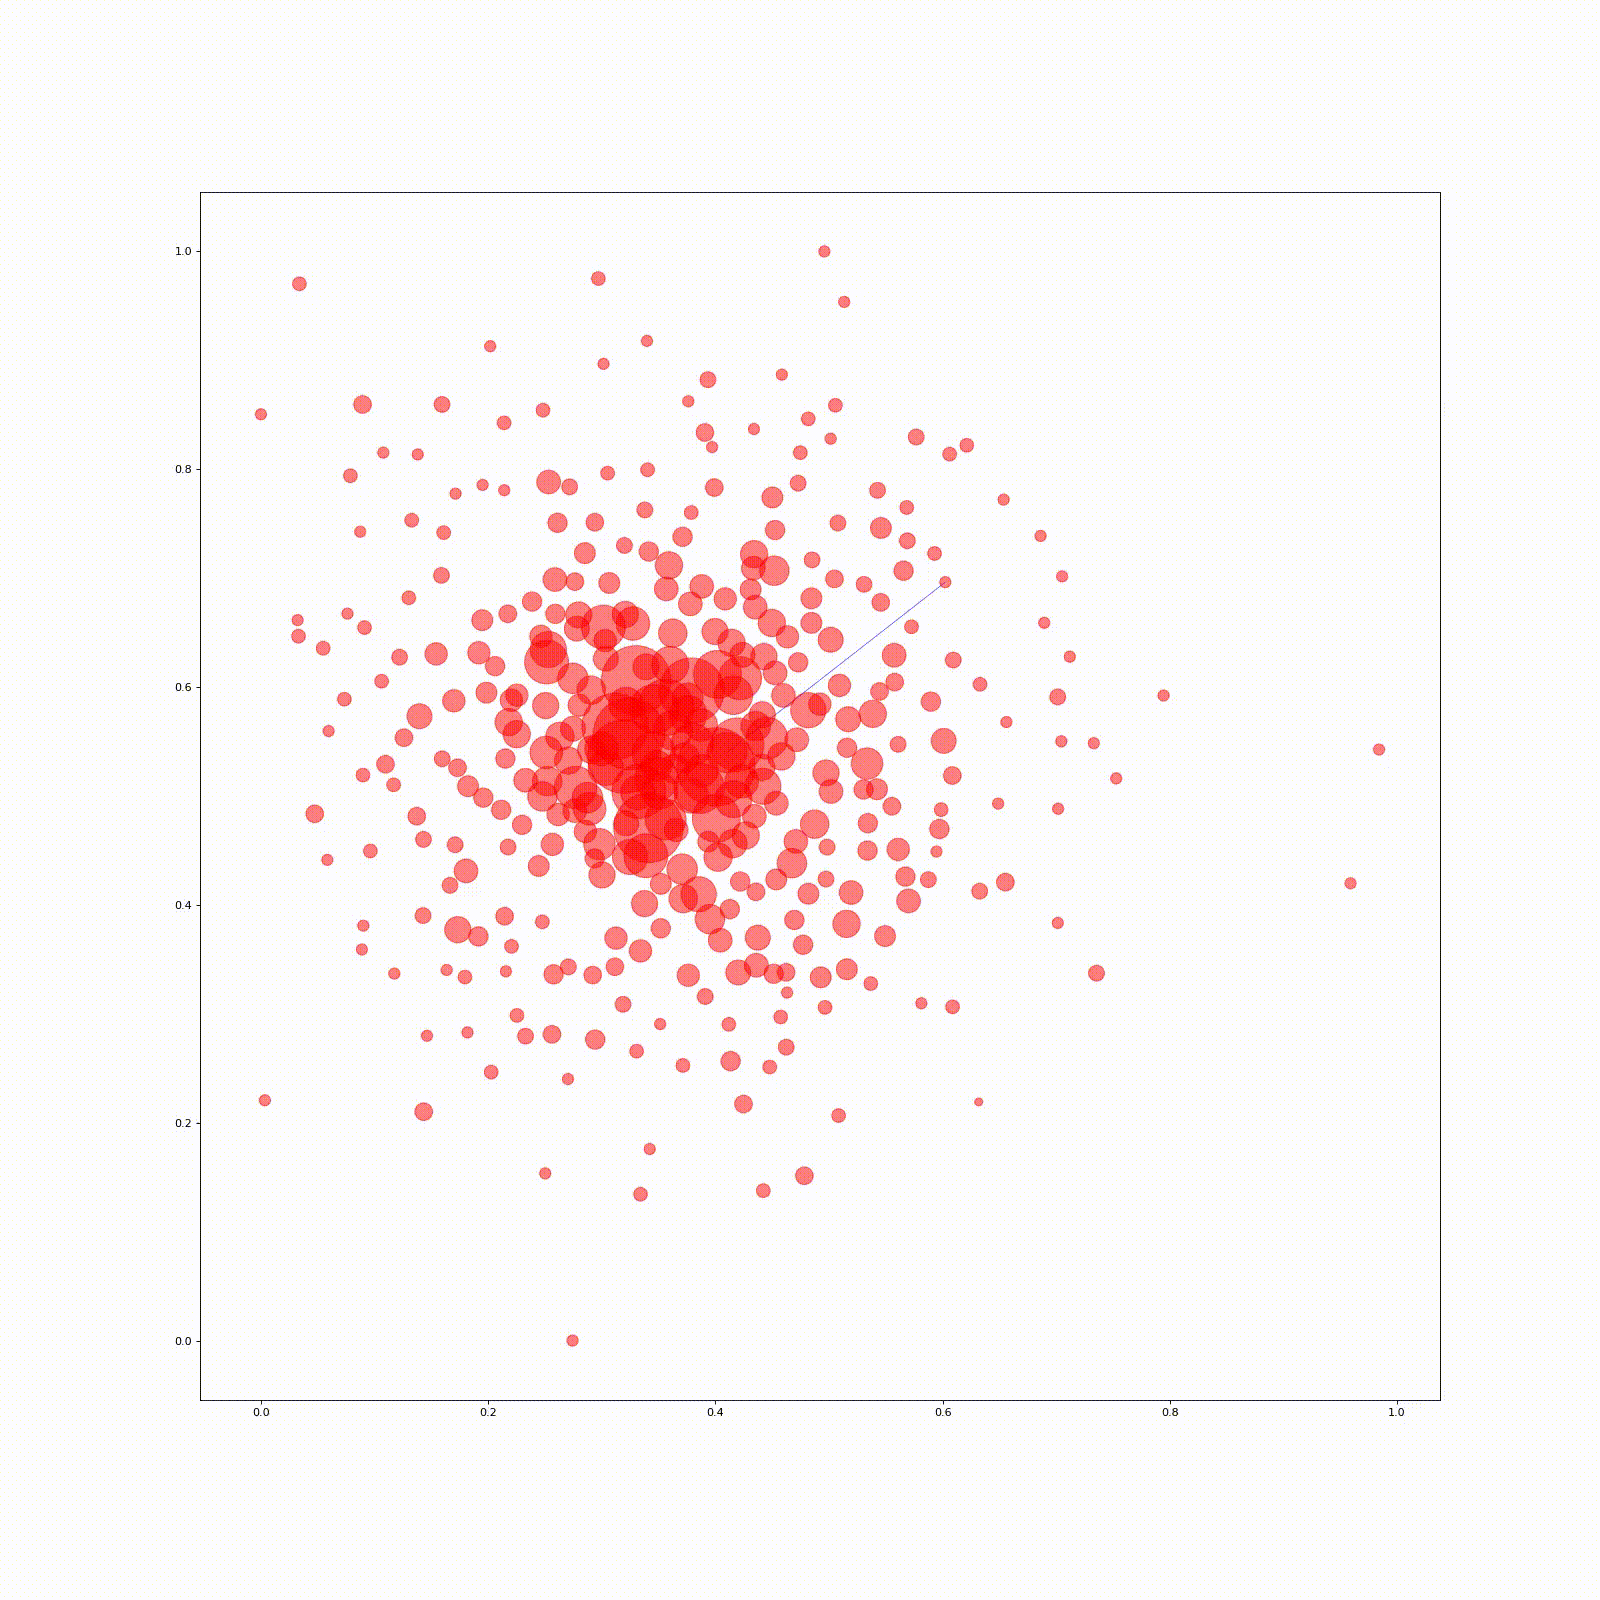

## Ego-Network

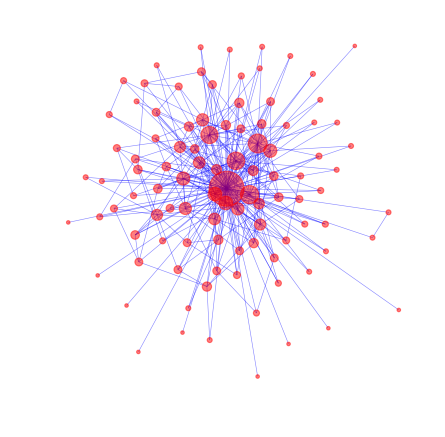

In [833]:
max_degree = sorted(SGcc_degree.values())[-1]
largest_hub = [n for n in SGcc_degree if SGcc_degree[n]==max_degree]

hub_ego = nx.ego_graph(SGcc, largest_hub[0])

plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')

pos = nx.spring_layout(SGcc)

#nx.draw(hub_ego, pos, node_size=50, width=0.5, alpha=0.5, edge_color='b')
#nx.draw_networkx_nodes(hub_ego, pos, nodelist=largest_hub, node_size=300, node_color='r')

nx.draw(hub_ego, nodelist=hub_ego.nodes(), node_size=[v * 10 for v in hub_ego.degree().values()], 
       width=0.5, alpha=0.5, edge_color='b')

plt.axis('off')
plt.show()

## K Core

In [ ]:
WGcc.remove_edges_from(WGcc.selfloop_edges())
SGcc.remove_edges_from(SGcc.selfloop_edges())

In [ ]:
i=1
while True:
    if len(nx.k_core(SGcc, i)) == 0:
        break
    else:
        print('Core exists for K=%d' % i)
        i += 1

In [ ]:
k_9 = nx.k_core(SGcc, 9)
degrees_k9 = k_9.degree()

In [ ]:
len(k_9.nodes())

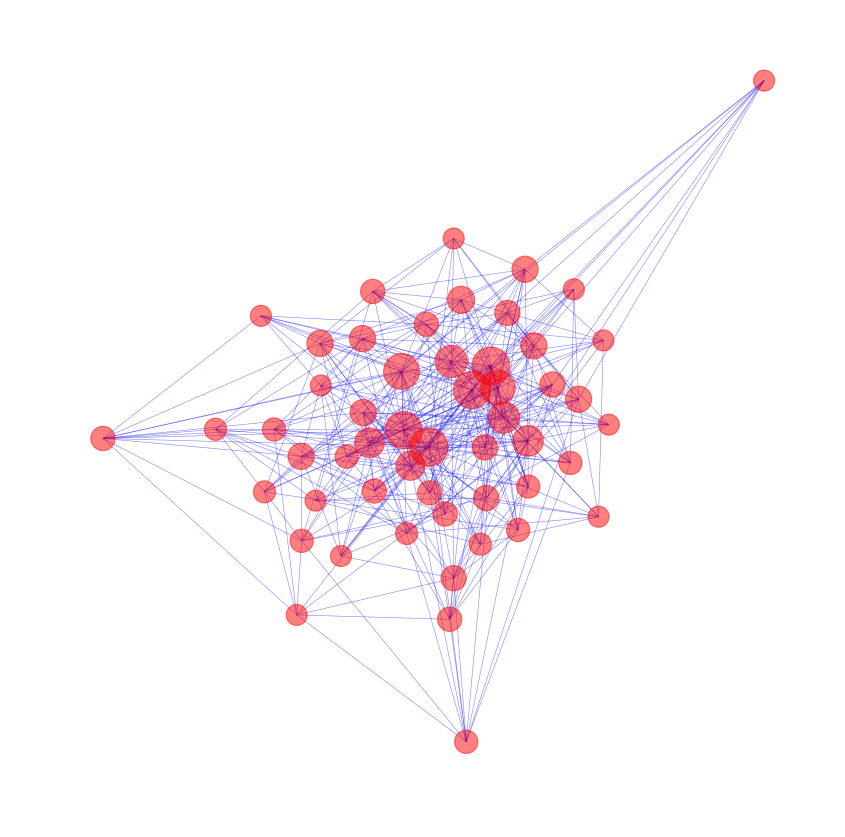

In [837]:
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

pos = nx.spring_layout(k_9)

nx.draw(k_9, pos, nodelist=degrees_k9.keys(), node_size=[v * 40 for v in degrees_k9.values()], 
       width=0.5, alpha=0.5, edge_color='b')

plt.axis('off')
plt.show()

## Hashtag Concurrency

In [ ]:
def extract(start, tweet):

    words = tweet.split()
    return [word[1:] for word in words if word[0] == start]

def strip_punctuation(s):
    #return s.translate(None, '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    return s.translate(str.maketrans('','','!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))

def extract_hashtags(tweet):
    # strip the punctuation on the tags you've extracted (directly)
    hashtags = [strip_punctuation(tag) for tag in extract('#', tweet)]
    # hashtags is now a list of hash-tags without any punctuation, but possibly with duplicates

    result = []
    for tag in hashtags:
        if tag not in result:  # check that we haven't seen the tag already (we know it doesn't contain punctuation at this point)
            result.append(tag)
    return result

In [835]:
df['hashtags'] = df['orignal_text'].apply(extract_hashtags)
df2 = df[['orignal_text', 'hashtags']]
df2 = df2[[len(p)>1 for p in df2['hashtags']]]
df2.head()

orignal_text  \
3   Rumbo a la marcha del #SiSePuede  \n\n@maurici...   
4   Junto a @herlombardi Vamos carajo la damos vue...   
6   Con mi hijo 😍😍😍\n#SiSePuedeBelgrano #LaDamosVu...   
10  Mirá quien nos espera hoy en el #SiSePuedeBelg...   
12  #SiSePuedeBelgrano #CompraDeVotos  #ElFuturoEs...   

                                             hashtags  
3   [SiSePuede, YoVoy, SiSePuedeBelgrano, JuntosPo...  
4                          [YoVoy, SiSePuedeBelgrano]  
6            [SiSePuedeBelgrano, LaDamosVueltaJuntos]  
10               [SiSePuedeBelgrano, 28S, 28SepYoVoy]  
12  [SiSePuedeBelgrano, CompraDeVotos, ElFuturoEsC...

In [ ]:
list_Hashtags = df2['hashtags'].tolist()
                   
H = nx.Graph()

for L in list_Hashtags:
    for i in range(len(L)):
        for j in range(i,len(L)):
            H.add_edge(L[i], L[j])

In [ ]:
H = sorted(nx.connected_component_subgraphs(H), key=len, reverse=True)[0]
degrees_h = H.degree()

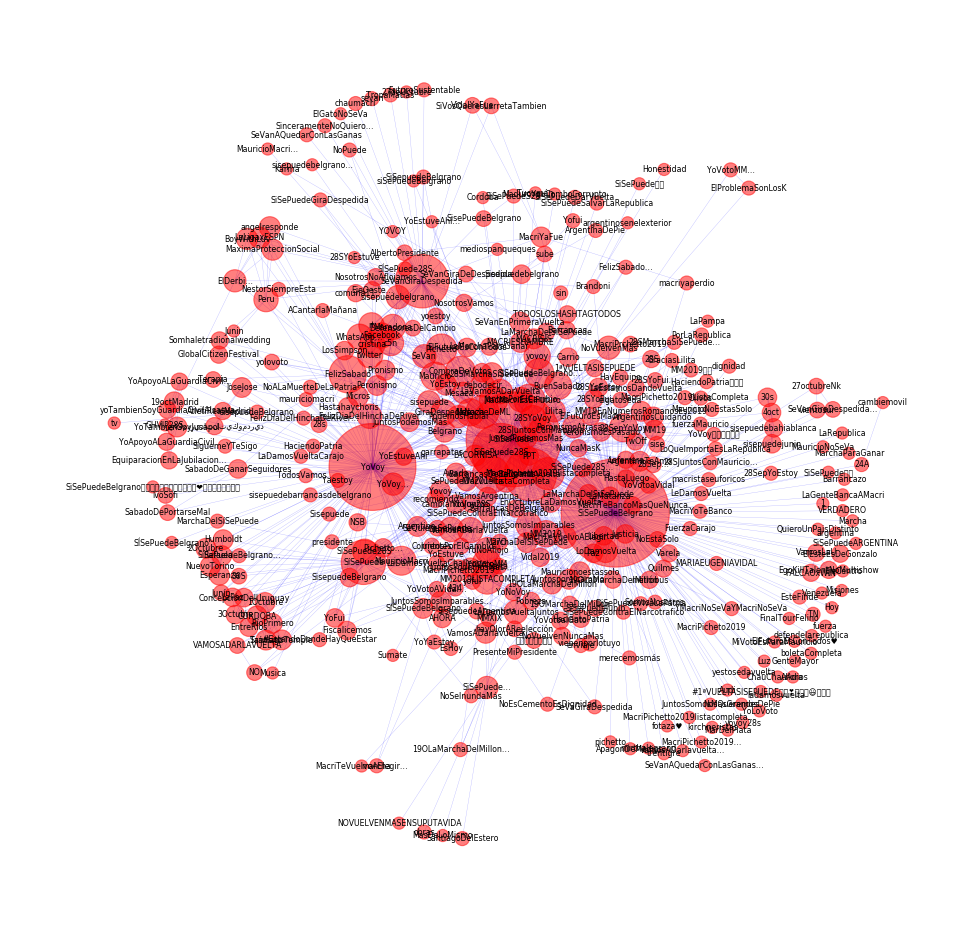

In [836]:
plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')

pos = nx.spring_layout(H)

# nodes
nx.draw_networkx_nodes(H, pos, nodelist=degrees_h.keys(), 
                       node_size=[v * 40 for v in degrees_h.values()], alpha=0.5)

# edges
nx.draw_networkx_edges(H, pos, width=0.3, alpha=0.3, edge_color='b')

# labels
nx.draw_networkx_labels(H, pos, font_size=7, font_family='sans-serif')

plt.axis('off')
plt.show()